# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

### Define Hyper Parameters for the  model

In [2]:
import numpy as np
import random
import copy
from collections import namedtuple, deque



import torch
import torch.nn.functional as F
import torch.optim as optim

# replay buffer size
BUFFER_SIZE = int(1e5)  
# minibatch size
BATCH_SIZE = 128    
# discount factor
GAMMA = 0.99  
# for update of target parameters
TAU = 1e-3      
# learning rate of the actor 
LR_ACTOR = 2e-4  
# learning rate of the critic
LR_CRITIC = 2e-4        
# L2 weight decay
WEIGHT_DECAY = 0        

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define agent actions , switching between different states, learn from sampled data and update the learning curve


In [3]:
class Agent():
    """This class will take state and action size as input and help
       the agent interact with environment"""
    
    def __init__(self, state_size, action_size, random_seed):
        """Using init to initialize class object for agent.
            state_size : denotes the state size (total states)
            action_size : denotes the action size (total actions that can be taken)
            seed : random seed ,value generated by random function in python 
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Build Actor Network 
        self.act_local = Actor(state_size, action_size, random_seed).to(device)
        self.act_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.act_local.parameters(), lr=LR_ACTOR)

        # Build Critic Network
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.copy_weights(self.act_target, self.act_local)
        self.copy_weights(self.critic_target, self.critic_local)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Setting up of Replay memory to ensure that rewards are accommodated in agent memory dynamically
        self.memory = ReplayMemory(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def copy_weights(self, target, source):
        """ copy weights from source to target network"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Adding the Q value params state,action ,reward and next_state in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # considering a random subset of experiences from memory for learning of agent
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.act_local.eval()
        with torch.no_grad():
            action = self.act_local(state).cpu().data.numpy()
        self.act_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Capturing q value i.e. a tuple consisting of current state, action , reward and next state
           Q_targets = r + γ * critic_target(next_state, act_target(next_state))
              where:
                act_target(state) -> action
                critic_target(state, action) -> Q-value

            experiences : tuple of (s, a, r, s') 
            gamma : discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        #update critic
        # Get predicted next-state actions and Q values from target models
        next_actions = self.act_target(next_states)
        Q_targets_next = self.critic_target(next_states, next_actions)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # Update the actor
        # Compute actor loss
        actions_pred = self.act_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        #Updating target network
        self.update(self.critic_local, self.critic_target, TAU)
        self.update(self.act_local, self.act_target, TAU)                     

    def update(self, l_model, t_model, tau):
        """Captures all Updates in model parameters
        θ_target = τ*θ_local + (1 - τ)*θ_target
     
            l_model : Fetching the weights from local model
            t_model : Feeding the weights as input to target model
            tau : interpolation parameter 
        """
        for t_param, l_param in zip(t_model.parameters(), l_model.parameters()):
            t_param.data.copy_(tau*l_param.data + (1.0-tau)*t_param.data)

### Noise handling: Ornstein-Uhlenbeck process, allowing linear transformation of state and other variables

In [4]:
class OUNoise:
    """Ornstein-Uhlenbeck process, allowing linear transformation of state and other variables"""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


#### Building Replay Memory 

In [5]:
class ReplayMemory:
    """Buffer memory to store the learning experiences and utilize the in
       learning better"""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

            action_size : action_size
            buffer_size : maximum size of internal memory
            batch_size :  batch size
            seed : random seed,value generated by random function in python 
            experience: tuple with Q-value consisting of state, action, reward, next state and dones
        """

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Helps add a new experience values to the memory 
           it appends the values and do not clear the values 
           which helps create a sample of Q value tuples in 
           the memory """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Selecting a random sample of experiences from replay memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """returns size of memory"""
        return len(self.memory)

###  Actor-Critic Model using Deep Deterministic Policy Gradient approach

In [6]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=0, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.

            state_size : Dimension of each state
            action_size : Dimension of each action
            seed : Random seed
            fc1_units : Number of nodes in first hidden layer
            fc2_units : Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed=0, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
            state_size : Dimension of each state
            action_size : Dimension of each action
            seed : Random seed
            fcs1_units : Number of nodes in the first hidden layer
            fc2_units : Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [7]:
! pip install unityagents

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [9]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [10]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [11]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


## 4. It's Your Turn!
Now it's your turn to train your own agent to solve the environment! A few important notes:

   --> When training the environment, set train_mode=True, so that the line for resetting the environment looks like the              following: env_info = env.reset(train_mode=True)[brain_name]
   
   --> To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a        new file! You can see the list of files in the workspace by clicking on Jupyter in the top left corner of the notebook.
   
   --> In this coding environment, you will not be able to watch the agents while they are training. However, after training          the agents, you can download the saved model weights to watch the agents on your own machine!

In [12]:
from collections import deque
import torch

agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

def train_deep_policy_grad(episodes=1000, max_time=10000, frequency=100):
    """DDQN Algorithm.
        Following are the Input values consumed by training function
        episodes : total number of training episodes
        max_time : maximum number of timesteps per episode
        frequency : frequency of printing information throughout iteration """
    
    scores = []  # List to capture score at intermediate points
    scores_deque = deque(maxlen=frequency)
    
    for i in range(1, episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        
        for t in range(max_time):
            action = agent.act(state)          # select an action
       
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # take step with agent (including learning)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        
        scores_deque.append(score)       # save most recent score
        scores.append(score)             # save most recent score

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)), end="")
        
        if i % frequency == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)))
            torch.save(agent.act_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)))
            torch.save(agent.act_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

In [13]:
scores = train_deep_policy_grad(episodes = 500)

Episode 100	Average Score: 3.55
Episode 200	Average Score: 23.62
Episode 244	Average Score: 30.01
Environment solved in 244 episodes!	Average Score: 30.01


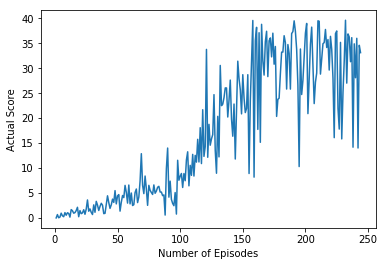

In [15]:
import matplotlib.pyplot as plt
np.random.seed(21)

fig = plt.figure()
ax = fig.add_subplot(111)


# Draw the line plot
plt.plot(np.arange(1, len(scores)+1), scores)

# Define the label of the plots
plt.xlabel('Number of Episodes')
plt.ylabel('Actual Score')

     
# Display the plot
plt.show()


When finished, you can close the environment.

In [16]:
env.close()